## Grupo:
## Andrea Blatter, Fernanda Pucheta, Cesar Zamboni

In [30]:
#!pip install xgboost
#!pip install seaborn 
#!pip install matplotlib

In [31]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#### Código Agregado ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings(action="ignore")


In [32]:
### Loading Data
data = pd.read_csv('data/base_tarjeta_credito.csv')


## Preparamos el tag y el dataset completo

In [33]:
data.head()

,Unnamed: 0,email,cliente,FechaSaldos,periodo_cli,periodo,cant_productos,cant_PF,cant_TC,cant_PP,...,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,target,target2
0,0,cliente@mail.com,0,2019-12-06 09:45:00,24240,24240,2,0,0,0,...,0,9440.56,0.00,0.0,0,4577.00,0,NaN,0.0,0.0
1,1,cliente@mail.com,1,2019-12-06 09:45:00,24240,24240,1,0,0,0,...,0,5029.59,0.00,0.0,0,8813.89,0,NaN,0.0,0.0
2,2,cliente@mail.com,2,2019-12-06 09:45:00,24240,24240,1,0,0,0,...,0,50156.32,0.00,0.0,0,10387.20,0,0.0,0.0,0.0
3,3,cliente@mail.com,3,2019-12-06 09:45:00,24240,24240,6,0,3,0,...,0,26082.85,0.00,0.0,0,600.00,0,1.0,0.0,0.0
4,4,cliente@mail.com,4,2019-12-06 09:45:00,24240,24240,6,1,2,0,...,0,103080.40,470.04,0.0,0,1618.19,0,0.0,0.0,1.0


In [34]:
data.columns

Index(['Unnamed: 0', 'email', 'cliente', 'FechaSaldos', 'periodo_cli',
       'periodo', 'cant_productos', 'cant_PF', 'cant_TC', 'cant_PP',
       'FechaUltMovCA', 'cant_seguros', 'importe_consumos', 'Edad', 'Sexo',
       'SaldoPromedioCAPesos', 'SaldoPromedioCADolares',
       'SaldoPromedioCCAcreedor', 'TotalConsumoTD', 'TipoCuentaAcredHab',
       'CategoriaProducto', 'FechaVinculacion', 'cuotas_faltantes_1',
       'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target', 'target2'],
      dtype='object')

In [35]:
data['CategoriaProducto']

0         JUB00021
1         JUB00021
2         JUB00021
3         JUB00021
4         K  00021
5         JUB00021
6         GRL00003
7         K  00021
8         JUB00021
9         K  00021
10        JUB00021
11        GRL00003
12        GRL00003
13        K  00021
14        GRL00003
15        GRL00003
16        GRL00003
17        GRL00003
18        GRL00003
19        GRL00003
20        GRL00003
21        JUB00021
22        JUB00021
23        GRL00003
24        GRL00003
25        K  00021
26        PC200003
27        K  00021
28        JUB00021
29        K  00021
            ...   
494857    PRI00018
494858    CON00001
494859    CON00001
494860    PRI00018
494861    PRI00018
494862    COE00001
494863    COE00001
494864    PRI00001
494865    CON00001
494866    PRI00001
494867    CON00001
494868    PRI00018
494869    CON00001
494870    CON00001
494871    CON00001
494872    PRI00001
494873    PRI00001
494874    CON00001
494875    PRI00018
494876    PRI00001
494877    CON00001
494878    PR

In [36]:
data['target'].value_counts()

0.0    491817
1.0      3070
Name: target, dtype: int64

In [37]:
data['target2'].value_counts()

0.0    318543
1.0    176344
Name: target2, dtype: int64

In [38]:
data[data['target']==0.0]['target2'].value_counts()

0.0    318543
1.0    173274
Name: target2, dtype: int64

In [39]:
data[data['target']==1.0]['target2'].value_counts()

1.0    3070
Name: target2, dtype: int64

In [40]:
data[data['cant_TC']==0]['target'].value_counts()

0.0    99056
1.0     1196
Name: target, dtype: int64

### Binarizacion de variables categoricas

Vamos a convertir en variables binarias a algunas variables categóricas que podrían aportar valor al modelo, como por ejemplo las categorías de segmentación y microsegmentación de clientes, para luego poder calcular correlciones con el target.

In [41]:
#creamos un data frame que solo contiene las variables numericas
df_numeric = data.select_dtypes('number')
columns_num=df_numeric.columns
columns_num


Index(['Unnamed: 0', 'cliente', 'periodo_cli', 'periodo', 'cant_productos',
       'cant_PF', 'cant_TC', 'cant_PP', 'cant_seguros', 'importe_consumos',
       'Edad', 'SaldoPromedioCAPesos', 'SaldoPromedioCADolares',
       'SaldoPromedioCCAcreedor', 'TotalConsumoTD', 'TipoCuentaAcredHab',
       'cuotas_faltantes_1', 'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target', 'target2'],
      dtype='object')

In [42]:
columns_cat = [col for col in data.columns if col not in columns_num]
columns_cat

['email',
 'FechaSaldos',
 'FechaUltMovCA',
 'Sexo',
 'CategoriaProducto',
 'FechaVinculacion']

In [43]:
df_categoric=data[columns_cat]
df_categoric

,email,FechaSaldos,FechaUltMovCA,Sexo,CategoriaProducto,FechaVinculacion
0,cliente@mail.com,2019-12-06 09:45:00,2019-12-02 00:00:00,M,JUB00021,2017-07-26 00:00:00
1,cliente@mail.com,2019-12-06 09:45:00,2019-12-04 00:00:00,F,JUB00021,2015-09-25 00:00:00
2,cliente@mail.com,2019-12-06 09:45:00,2019-12-05 00:00:00,F,JUB00021,NaN
3,cliente@mail.com,2019-12-06 09:45:00,2019-12-05 00:00:00,F,JUB00021,NaN
4,cliente@mail.com,2019-12-06 09:45:00,2019-12-05 00:00:00,F,K 00021,NaN
5,cliente@mail.com,2019-12-06 09:45:00,2019-11-28 00:00:00,M,JUB00021,2017-12-26 00:00:00
6,cliente@mail.com,2019-12-06 09:45:00,2019-12-05 00:00:00,M,GRL00003,2006-07-28 00:00:00
7,cliente@mail.com,2019-12-06 09:45:00,2019-12-03 00:00:00,M,K 00021,NaN
8,cliente@mail.com,2019-12-06 09:45:00,2019-12-03 00:00:00,F,JUB00021,2018-07-26 00:00:00
9,cliente@mail.com,2019-12-06 09:45:00,2019-12-05 00:00:00,F,K 00021,NaN


In [44]:
#Analizamos que variables podrian ser binarizadas segun la cantidad de valores unicos que posean, de manera de no necesitar demasiadas columnas extras
for i in columns_cat:
    print(i,":",df_categoric[i].unique())

email : ['cliente@mail.com']
FechaSaldos : ['2019-12-06 09:45:00' '2020-01-08 09:48:00' '2020-02-07 14:13:00']
FechaUltMovCA : ['2019-12-02 00:00:00' '2019-12-04 00:00:00' '2019-12-05 00:00:00'
 '2019-11-28 00:00:00' '2019-12-03 00:00:00' '2019-11-19 00:00:00'
 '2019-11-29 00:00:00' '2019-11-21 00:00:00' '2019-07-10 00:00:00'
 '2019-11-27 00:00:00' '2017-03-03 00:00:00' nan '2018-02-21 00:00:00'
 '2019-11-22 00:00:00' '2019-11-12 00:00:00' '2018-11-12 00:00:00'
 '2019-11-20 00:00:00' '2019-08-28 00:00:00' '2019-11-25 00:00:00'
 '2019-11-26 00:00:00' '2018-01-10 00:00:00' '2019-11-11 00:00:00'
 '2019-11-05 00:00:00' '2019-11-15 00:00:00' '2019-11-13 00:00:00'
 '2018-10-08 00:00:00' '2019-09-16 00:00:00' '2019-01-14 00:00:00'
 '2019-07-05 00:00:00' '2019-11-14 00:00:00' '2019-03-01 00:00:00'
 '2019-01-15 00:00:00' '2019-11-07 00:00:00' '2019-05-09 00:00:00'
 '2017-03-09 00:00:00' '2019-09-27 00:00:00' '2017-12-11 00:00:00'
 '2019-11-08 00:00:00' '2017-04-10 00:00:00' '2019-08-02 00:00:00

FechaVinculacion : ['2017-07-26 00:00:00' '2015-09-25 00:00:00' nan ... '2020-01-10 00:00:00'
 '2020-01-14 00:00:00' '2020-01-16 00:00:00']


In [45]:
'''
A continuacion las variables seleccionadas:

FechaSaldos : ['2019-12-06 09:45:00' '2020-01-08 09:48:00' '2020-02-07 14:13:00']
Sexo : ['M' 'F' ' ']
CategoriaProducto : ['JUB00021' 'K  00021' 'GRL00003' 'PC200003' nan 'L  00021' 'PC100003'
 'CCL00003' 'GRA00001' 'SUB00003' 'RED00003' 'K  00001' 'PC100001'
 'Q  00003' 'LIB00003' 'WEB00003' 'DNI00003' 'JOV00003' 'PC300003'
 'PIG00003' 'ADO00003' 'FIU00003' 'BSU00003' 'ACT00001' 'PRI00001'
 'CON00001' 'PRI00018' 'COF00001' 'COE00001']
'''

"\nA continuacion las variables seleccionadas:\n\nFechaSaldos : ['2019-12-06 09:45:00' '2020-01-08 09:48:00' '2020-02-07 14:13:00']\nSexo : ['M' 'F' ' ']\nCategoriaProducto : ['JUB00021' 'K  00021' 'GRL00003' 'PC200003' nan 'L  00021' 'PC100003'\n 'CCL00003' 'GRA00001' 'SUB00003' 'RED00003' 'K  00001' 'PC100001'\n 'Q  00003' 'LIB00003' 'WEB00003' 'DNI00003' 'JOV00003' 'PC300003'\n 'PIG00003' 'ADO00003' 'FIU00003' 'BSU00003' 'ACT00001' 'PRI00001'\n 'CON00001' 'PRI00018' 'COF00001' 'COE00001']\n"

In [46]:
#Ponemos las variables seleccionadas en un data frame y las binarizamos
to_binarize=df_categoric[['FechaSaldos','Sexo','CategoriaProducto']]
df_binarized=pd.get_dummies(to_binarize)
df_binarized.head()

,FechaSaldos_2019-12-06 09:45:00,FechaSaldos_2020-01-08 09:48:00,FechaSaldos_2020-02-07 14:13:00,Sexo_,Sexo_F,Sexo_M,CategoriaProducto_ACT00001,CategoriaProducto_ADO00003,CategoriaProducto_BSU00003,CategoriaProducto_CCL00003,...,CategoriaProducto_PC100003,CategoriaProducto_PC200003,CategoriaProducto_PC300003,CategoriaProducto_PIG00003,CategoriaProducto_PRI00001,CategoriaProducto_PRI00018,CategoriaProducto_Q 00003,CategoriaProducto_RED00003,CategoriaProducto_SUB00003,CategoriaProducto_WEB00003
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
#Concatenamos el data frame de variables numericas y el de variables binarizadas, ya que ahora todas son numericas
df_numeric=pd.concat([df_numeric, df_binarized], axis=1, sort=False)

### Correlaciones

In [48]:
def fetch_features(df, name_y='Target'):
    """
    Funcion para obtener las variables ordenadas con mayor correlacion con respecto al target
    Recibe como parametro la variable a predecir.
    Devuelve un data frame con las variables ordenadas y su correlación con el target.
    """
    name_x=[]
    cors=[]
    
    for i in df.columns:
        if not i ==name_y:
            name_x.append(i)
            cors.append(df[name_y].corr(df[i]))
            
    return pd.DataFrame({
        "name":name_x,
        "cors": cors,
        "abs_cors": np.fabs(cors)
    })

In [49]:
df_numeric.drop(columns=['periodo','target2','cliente'], inplace=True)

In [50]:
#Llamo a la funcion que devuelve la correlación de cada variable con el Target y las ordeno
best_corr=fetch_features(df_numeric, 'target').sort_values('abs_cors', ascending=False)
best_corr.head(40)

,name,cors,abs_cors
36,FechaSaldos_2020-02-07 14:13:00,0.058345,0.058345
1,periodo_cli,0.055523,0.055523
34,FechaSaldos_2019-12-06 09:45:00,-0.042059,0.042059
52,CategoriaProducto_JUB00021,0.034764,0.034764
8,Edad,0.030171,0.030171
35,FechaSaldos_2020-01-08 09:48:00,0.022741,0.022741
54,CategoriaProducto_K 00021,-0.018362,0.018362
0,Unnamed: 0,-0.016233,0.016233
25,cant_TC_ant_2,-0.015423,0.015423
16,cant_TC_ant_1,-0.014271,0.014271


In [100]:
#paso a una lista los nombres de las variables con mayor correlación
#Puedo jugar con la cantidad para ver cómo se comporta el modelo
lst=list(best_corr.head(11).name)
#agrego el nombre de la variable objetivo
lst.append('target')

In [101]:
#creo un nuevo data frame formado por las columnas de mayor correlación y el vector objetivo
df_best_corr= df_numeric[[c for c in df_numeric.columns if c in lst]]

In [102]:
df_best_corr.columns

Index(['Unnamed: 0', 'periodo_cli', 'cant_TC', 'Edad', 'cant_TC_ant_1',
       'cant_TC_ant_2', 'target', 'FechaSaldos_2019-12-06 09:45:00',
       'FechaSaldos_2020-01-08 09:48:00', 'FechaSaldos_2020-02-07 14:13:00',
       'CategoriaProducto_JUB00021', 'CategoriaProducto_K  00021'],
      dtype='object')

In [103]:
#Nuestro tag estara dado por la columna target, al que llamaremos y 
y = df_best_corr['target']

In [104]:
df_best_corr.drop(columns=['Unnamed: 0','target'], inplace=True)

In [105]:
df_best_corr.columns

Index(['periodo_cli', 'cant_TC', 'Edad', 'cant_TC_ant_1', 'cant_TC_ant_2',
       'FechaSaldos_2019-12-06 09:45:00', 'FechaSaldos_2020-01-08 09:48:00',
       'FechaSaldos_2020-02-07 14:13:00', 'CategoriaProducto_JUB00021',
       'CategoriaProducto_K  00021'],
      dtype='object')

Ahora tenemos que crear la variable x que contendra la informacion para el entrenamiento del modelo (data)

Tenemos que quitar la columna SUSCRIBER_KEY que es una columna de valores unicos y que solo sirve para identificar a cada linea, pero no para entrenar el modelo. Y obviamente tampoco tiene sentido poner la columna Target dentro de los datos de 
entrenamiento, sino el modelo va a conocer perfectamente que persona abandona o no el servicio
Otras columnas que eliminaremos del modelo seran commercial_activation_data, date, dayofweek, month, year, period
ya que ya hicimos su analisis y las utilizamos pero ya no tienen mas sentido

Y solamente tomamos en cuenta las columnas que son numericas

In [106]:
columns = [col for col in df_best_corr.columns if col not in ['periodo_cli', 'FechaSaldos_2019-12-06 09:45:00', 'FechaSaldos_2020-01-08 09:48:00',
       'FechaSaldos_2020-02-07 14:13:00', 'CategoriaProducto_JUB00021',
       'CategoriaProducto_K  00021']]
columns

['cant_TC', 'Edad', 'cant_TC_ant_1', 'cant_TC_ant_2']

In [107]:
X = df_best_corr[columns]

In [108]:
#ahora nos quedamos con los valores de cada variable
#values pasa de serie a array
y = y.values
X = X.values

Ahora que tenemos las dos variables X e y, debemos realizar una division del dataset en un dataset de entrenamiento y uno de testeo

Usaremos el metodo Train Test Split, el cual se encarga de dividir nuestro conjunto original en un conjunto de entrenamiento y un conjunto de testeo

In [109]:
from sklearn.model_selection import train_test_split # cargamos el metodo

In [110]:
#Separamos el conjunto entrenamiento y test con el metodo train_test_split y se lo asignamos a las distintas variables
X_train, X_test, y_train, y_test = train_test_split(X,y)
#por default el conjunto se separara en 75% para el train y 25% para el test

In [111]:
X.shape

(494887, 4)

In [112]:
X_train.shape

(371165, 4)

In [113]:
X_test.shape

(123722, 4)

Podemos observar que como separamos la variable X en train y test, la suma de registros de X_train y X_test 
dara la cantidad de registros de X. En el caso de la variable y ocurriria exactamente igual.

A su vez, X_train tendra la misma cantidad de registros o filas que y_train, y X_test la misma que y_test.

In [114]:
#utilizaremos xgboost como modelo predictivo
!pip install xgboost

In [115]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#estas herramientas nos permiten calcular metricas del modelo 

In [116]:
def train(X_train,y_train):
    """
    Función para entrenar el modelo.
    
    Parameters
    -----------
    
    X_train: pd.DataFrame
        Dataset de Train, listo para entrenar y sin tag
        
    y_train: pd.DataFrame
        Dataset de tag, es el tag correspondiente al dataset de train.
        
    Return
    ----------
    Modelo Entrenado.
    
    """
    xgb_model = xgb.XGBClassifier()
    #instanciamos el clasificador xgb
    
    print("Comienza entrenamiento del modelo XGBoost")

    xgb_model.fit(X_train, y_train)
    #el metodo fit llama al modelo matematico que entrenara el modelo 
    #xgb model ahora va a ser un modelo entrenado
    
    print("Entrenamiento finalizado\n")

    print("Haciendo las predicciones\n\n")

    #con este modelo ya entrenado llamo al metodo predict
    XGB_preds = xgb_model.predict(X_test)
    #comparo mis predicciones con el valor real que tengo guardo en y_test 
    print(classification_report(y_test, XGB_preds))
    print(confusion_matrix(y_test, XGB_preds))
    return xgb_model

In [117]:
def predict(data_to_predict, xgb_model):
    """Funcion para hacer el entrenamiento del modelo y guardarlo en un archivo .pkl

    Parameters
    -----------

    data_to_predict : pd.DataFrame
        DataFrame listo para predecir, con las mismas transformaciones que el de entrenamiento.
        
    xgb_model : xgb.XGBClassifier
        Modelo entrenado de XGBoost

    Return
    -----------
    Dataframe de 3 columnas, la identificacion del cliente, la prediccion de la clase y la probabilidad de que el cliente
    permanezca en el servicio.


    """
    print("\n\n-------------------------")
    print("Ingreso a la funcion de prediccion\n")

    XGB_preds = xgb_model.predict_proba(X)
    #si en vez de un predict proba hacemos un predict nos daria como resultado 0 y 1 directamente, redondeando
    
    return XGB_preds

In [118]:
modelo = train(X_train, y_train)

Comienza entrenamiento del modelo XGBoost
Entrenamiento finalizado

Haciendo las predicciones


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    122940
         1.0       0.00      0.00      0.00       782

   micro avg       0.99      0.99      0.99    123722
   macro avg       0.50      0.50      0.50    123722
weighted avg       0.99      0.99      0.99    123722

[[122940      0]
 [   782      0]]


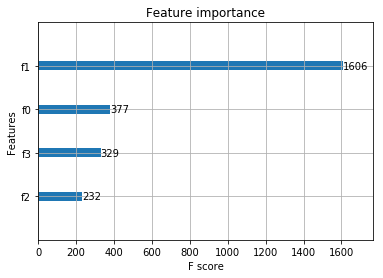

In [119]:
from xgboost import plot_importance
plot_importance(modelo, )

In [73]:
resultado = predict(X_test,modelo)



-------------------------
Ingreso a la funcion de prediccion



In [74]:
resultado
#podemos ver un array con las probabilidades de que cada registro valga 0 o 1
#por ejemplo en el primer registro tenemos 86% de probabilidades de que valga 0, y 13% de que valga 1

array([[0.9939806 , 0.00601941],
       [0.99446887, 0.00553115],
       [0.9939806 , 0.00601941],
       ...,
       [0.9988375 , 0.00116251],
       [0.9988375 , 0.00116251],
       [0.9988375 , 0.00116251]], dtype=float32)

In [120]:
resultado = pd.DataFrame(resultado)

In [121]:
resultado.describe()

,0,1
count,494887.000000,494887.000000
mean,0.995987,0.006153
std,0.010674,0.010458
min,0.331262,0.000012
25%,0.992333,0.001242
50%,0.996186,0.003814
75%,0.998758,0.007667
max,0.999988,0.668738


In [122]:
#podriamos determinar por ejemplo que tengan 1 aquellos que tengan un valor de probabilidad mayor a 0.6 
(resultado[1] > 0.6).astype(int)

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
494857    0
494858    0
494859    0
494860    0
494861    0
494862    0
494863    0
494864    0
494865    0
494866    0
494867    0
494868    0
494869    0
494870    0
494871    0
494872    0
494873    0
494874    0
494875    0
494876    0
494877    0
494878    0
494879    0
494880    0
494881    0
494882    0
494883    0
494884    0
494885    0
494886    0
Name: 1, Length: 494887, dtype: int32

In [126]:
pd.DataFrame((resultado[1] > 0.6).astype(int)).to_csv('resultado.csv')